In [30]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import numpy as np
import librosa.display
import IPython.display as ipd

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

# to play the audio files
from IPython.display import Audio
import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
# from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
from tensorflow.keras import layers
from PIL import Image
from tensorflow. keras.utils import to_categorical
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten, concatenate
from tensorflow.keras.models import Model
import warnings
import sys

if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
! pip install keras
! pip install tensorflow

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d ejlok1/cremad

 99% 445M/451M [00:05<00:00, 116MB/s]
100% 451M/451M [00:05<00:00, 91.0MB/s]


In [ ]:
!unzip cremad.zip

Streaming output truncated to the last 5000 lines.
  inflating: AudioWAV/1031_DFA_DIS_XX.wav  
  inflating: AudioWAV/1031_DFA_FEA_XX.wav  
  inflating: AudioWAV/1031_DFA_HAP_XX.wav  
  inflating: AudioWAV/1031_DFA_NEU_XX.wav  
  inflating: AudioWAV/1031_DFA_SAD_XX.wav  
  inflating: AudioWAV/1031_IEO_ANG_HI.wav  
  inflating: AudioWAV/1031_IEO_ANG_LO.wav  
  inflating: AudioWAV/1031_IEO_ANG_MD.wav  
  inflating: AudioWAV/1031_IEO_DIS_HI.wav  
  inflating: AudioWAV/1031_IEO_DIS_LO.wav  
  inflating: AudioWAV/1031_IEO_DIS_MD.wav  
  inflating: AudioWAV/1031_IEO_FEA_HI.wav  
  inflating: AudioWAV/1031_IEO_FEA_LO.wav  
  inflating: AudioWAV/1031_IEO_FEA_MD.wav  
  inflating: AudioWAV/1031_IEO_HAP_HI.wav  
  inflating: AudioWAV/1031_IEO_HAP_LO.wav  
  inflating: AudioWAV/1031_IEO_HAP_MD.wav  
  inflating: AudioWAV/1031_IEO_NEU_XX.wav  
  inflating: AudioWAV/1031_IEO_SAD_HI.wav  
  inflating: AudioWAV/1031_IEO_SAD_LO.wav  
  inflating: AudioWAV/1031_IEO_SAD_MD.wav  
  inflating: AudioWAV/103

In [31]:
class DataPreparation:
    def __init__(self, data_path):
        self.data_path = data_path
        self.dir_list = os.listdir(data_path)

    def prepare_dataframe(self):
        emotionG = []
        gender = []
        emotionO = []
        path = []
        female_ids = [1002, 1003, 1004, 1006, 1007, 1008, 1009, 1010, 1012, 1013, 1018, 1020, 1021,
                      1024, 1025, 1028, 1029, 1030, 1037, 1043, 1046, 1047, 1049, 1052, 1053, 1054,
                      1055, 1056, 1058, 1060, 1061, 1063, 1072, 1073, 1074, 1075, 1076, 1078, 1079,
                      1082, 1084, 1089, 1091]

        temp_dict = {"SAD": "sad", "ANG": "angry", "DIS": "disgust", "FEA": "fear",
                     "HAP": "happy", "NEU": "neutral"}

        def get_emotion_crema(filename, ids=female_ids, dc=temp_dict):
            filename = filename.split("_")
            emotionG1 = dc[filename[2]]
            if int(filename[0]) in ids:
                emotionG2 = "_female"
            else:
                emotionG2 = "_male"
            emotionG = emotionG1 + emotionG2
            return (emotionG, emotionG1, emotionG2[1:])

        for i in self.dir_list:
            emotionG.append(get_emotion_crema(i)[0])
            emotionO.append(get_emotion_crema(i)[1])
            gender.append(get_emotion_crema(i)[2])
            path.append(os.path.join(self.data_path, i))

        CREMA_df = pd.DataFrame(emotionG, columns=['emotionG_label'])
        CREMA_df['source'] = 'CREMA'
        CREMA_df = pd.concat([CREMA_df, pd.DataFrame(gender, columns=['gender'])], axis=1)
        CREMA_df = pd.concat([CREMA_df, pd.DataFrame(emotionO, columns=['emotion'])], axis=1)
        CREMA_df = pd.concat([CREMA_df, pd.DataFrame(path, columns=['path'])], axis=1)
        CREMA_df = CREMA_df.iloc[:200]

        return CREMA_df

In [32]:
class DataVisualization:
    def __init__(self, data):
        self.data = data

    def plot_emotion_count(self):
        plt.figure(figsize=(8, 6))
        plt.title('Count of Emotions', size=16)
        sns.countplot(data=self.data, x='emotion')
        plt.ylabel('Count', size=12)
        plt.xlabel('Emotions', size=12)
        sns.despine(top=True, right=True, left=False, bottom=False)
        plt.xticks(rotation=45)
        plt.show()

In [33]:
class AudioVisualizer:
    def __init__(self):
        pass

    def create_waveplot(self, data, sr, e):
        plt.figure(figsize=(10, 3))
        plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
        librosa.display.waveshow(data, sr=sr)
        plt.xlabel('Time')
        plt.ylabel('Amplitude')
        plt.show()

    def create_spectrogram(self, data, sr, e):
        plt.figure(figsize=(12, 3))
        plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
        X = librosa.stft(data)
        Xdb = librosa.amplitude_to_db(abs(X))
        librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
        plt.colorbar()
        plt.show()

In [34]:
class SpectrogramCreation:
    def __init__(self, df):
        self.df = df

    def create_mel_spectrogram(self, path, output_path):
        waveform, sample_rate = librosa.load(path)
        spectrogram = librosa.feature.melspectrogram(y=waveform, sr=sample_rate)
        spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)

        plt.figure(figsize=(10, 4))
        librosa.display.specshow(spectrogram_db, sr=sample_rate, x_axis=None, y_axis=None)
        plt.axis('off')

        plt.savefig(output_path, bbox_inches='tight', pad_inches=0)
        plt.close()

    def generate_spectrograms(self):
        for i in range(0, len(self.df)):
            path = self.df.iloc[i][4]
            output_path = (
                "/content/Spectrogram/"
                + path.split('/')[-1].split('.')[0] + ".jpg"
            )
            self.create_mel_spectrogram(path, output_path)
            self.df.at[i, 'melspectrogram_path'] = output_path
        display(self.df)

class ModelTraining:
    def __init__(self, model):
        self.model = model
#         self.model = self.create_model()
#         pass

    def load_spectrogram(self, image_path):
        image = Image.open(image_path)
        image = image.resize((588, 217))
        image = np.array(image)
        image = image / 255.0
        return image

    def data_generator(self, X, y, batch_size=32):
        num_samples = len(X)
        steps_per_epoch = num_samples // batch_size
        while True:
            for i in range(steps_per_epoch):
                batch_X = X[i * batch_size: (i + 1) * batch_size]
                batch_y = y[i * batch_size: (i + 1) * batch_size]
                batch_X_processed = np.array([self.load_spectrogram(image_path) for image_path in batch_X])
                batch_y_processed = np.array(batch_y)
                yield batch_X_processed, batch_y_processed

    def create_model():
        model = tf.keras.Sequential()
        model.add(layers.Conv2D(7, (5, 5), activation='relu', input_shape=(588, 217, 3)))
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Conv2D(1, (5, 5), activation='relu'))
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Dropout(0.25))
        model.add(layers.Conv2D(75, (5, 5), activation='relu'))
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Dropout(0.25))
        model.add(layers.Flatten())
        model.add(layers.Dense(45, activation='relu'))
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(6, activation='softmax'))

        return model

    def train_model(self, train_generator, test_generator,X_train,X_test):
        checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath='models/epoch_(epoch).h5',
            save_weights_only=False,
            save_best_only=False,
            verbose=1
        )
        self.model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        history = self.model.fit(
            train_generator,
            steps_per_epoch=len(X_train) // 32,
            epochs=50,
            validation_data=test_generator,
            validation_steps=len(X_test) // 32,
            callbacks=[checkpoint_callback]
        )
        final_accuracy = history.history['accuracy'][-1]
        print(f"Final Accuracy after 50 epochs: {final_accuracy * 100:.2f}%")

        # Plot Training & Testing Loss
        plt.figure(figsize=(12, 6))

        # Plotting training and testing loss
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Testing Loss')
        plt.title('Training & Testing Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        # Plot Training & Testing Accuracy
        plt.subplot(1, 2, 2)
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Testing Accuracy')
        plt.title('Training & Testing Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.show()

In [35]:
class AudioFeatureExtractor:
    def __init__(self):
        pass

    def noise(self,data):
        noise_amp = 0.035*np.random.uniform()*np.amax(data)
        data = data + noise_amp*np.random.normal(size=data.shape[0])
        return data

    def stretch(self, data, rate=0.8):
        return librosa.effects.time_stretch(data, rate=rate)

    def shift(self,data):
        shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
        return np.roll(data, shift_range)

    def pitch(self,data, sampling_rate, pitch_factor=0.7):
        return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

    def extract_features(self, data, sample_rate):
        # ZCR
        result = np.array([])
        zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
        result = np.hstack((result, zcr))  # stacking horizontally

        # Chroma_stft
        stft = np.abs(librosa.stft(data))
        chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
        result = np.hstack((result, chroma_stft))  # stacking horizontally

        # MFCC
        mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
        result = np.hstack((result, mfcc))  # stacking horizontally

        # Root Mean Square Value
        rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
        result = np.hstack((result, rms))  # stacking horizontally

        # MelSpectogram
        mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
        result = np.hstack((result, mel))  # stacking horizontally

        return result

    def get_features(self, path):
        data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

        # without augmentation
        res1 = self.extract_features(data, sample_rate)  # Correctly referencing extract_features method
        result = np.array(res1)

        # data with noise
        noise_data = self.noise(data)  # Use 'self' to access the class method
        res2 = self.extract_features(noise_data, sample_rate)  # Correctly referencing extract_features method
        result = np.vstack((result, res2))  # stacking vertically

        # data with stretching and pitching
        new_data = self.stretch(data)  # Use 'self' to access the class method
        data_stretch_pitch = self.pitch(new_data, sample_rate)  # Use 'self' to access the class method
        res3 = self.extract_features(data_stretch_pitch, sample_rate)  # Correctly referencing extract_features method
        result = np.vstack((result, res3))  # stacking vertically

        return result

In [36]:
class EmotionRecognitionModel_MFCC:
    def __init__(self):
        self.model = None
        self.history = None

    def build_model(self, x_train, x_test, y_train, y_test):

        # Reshape features for CNN input
        x_train_cnn = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
        x_test_cnn = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

        # CNN branch
        cnn_input = Input(shape=(x_train_cnn.shape[1], x_train_cnn.shape[2]))
        cnn_model = Conv1D(64, kernel_size=3, activation='relu')(cnn_input)
        cnn_model = MaxPooling1D(pool_size=2)(cnn_model)
        cnn_model = Flatten()(cnn_model)
        cnn_model = Model(inputs=cnn_input, outputs=cnn_model)

        # LSTM branch
        lstm_input = Input(shape=(x_train_cnn.shape[1], x_train_cnn.shape[2]))
        lstm_model = LSTM(128)(lstm_input)
        lstm_model = Dropout(0.2)(lstm_model)
        lstm_model = Model(inputs=lstm_input, outputs=lstm_model)

        # Combine both branches
        combined = tf.keras.layers.concatenate([cnn_model.output, lstm_model.output])
        dense_layer = Dense(64, activation='relu')(combined)
        output_layer = Dense(y_train.shape[1], activation='softmax')(dense_layer)

        # Create the combined model
        self.model = Model(inputs=[cnn_model.input, lstm_model.input], outputs=output_layer)

    def compile_model(self, optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']):
        # Compile your model
        self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    def train_model(self, x_train, y_train, x_test, y_test, epochs=50, batch_size=16):
        # Train your model
        self.history = self.model.fit([x_train, x_train], y_train, epochs=epochs, batch_size=batch_size,
                                      validation_data=([x_test, x_test], y_test), verbose=1)

    def evaluate_model(self, x_test, y_test):
        # Evaluate model accuracy and create a confusion matrix
        accuracy = self.model.evaluate([x_test, x_test], y_test, verbose=0)[1]
        print(f"Accuracy: {accuracy * 100:.2f}%")

        # Predict probabilities on the test set
        y_pred_probs = self.model.predict([x_test, x_test])
        # Convert probabilities to class labels
        y_pred = np.argmax(y_pred_probs, axis=1)
        # Convert one-hot encoded labels back to categorical labels for y_test
        y_test_labels = np.argmax(y_test, axis=1)
        # Calculate confusion matrix
        conf_matrix = confusion_matrix(y_test_labels, y_pred)

        # Plot confusion matrix heatmap
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', cbar=False)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()

        # Calculate accuracy
        accuracy = accuracy_score(y_test_labels, y_pred)
        print(f"Accuracy: {accuracy * 100:.2f}%")

    def plot_training_history(self):
        # Plot training and testing accuracy/loss history
        epochs = range(len(self.history.history['accuracy']))
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.history.history['accuracy'], label='Training Accuracy')
        plt.plot(epochs, self.history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(epochs, self.history.history['loss'], label='Training Loss')
        plt.plot(epochs, self.history.history['val_loss'], label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.tight_layout()
        plt.show()


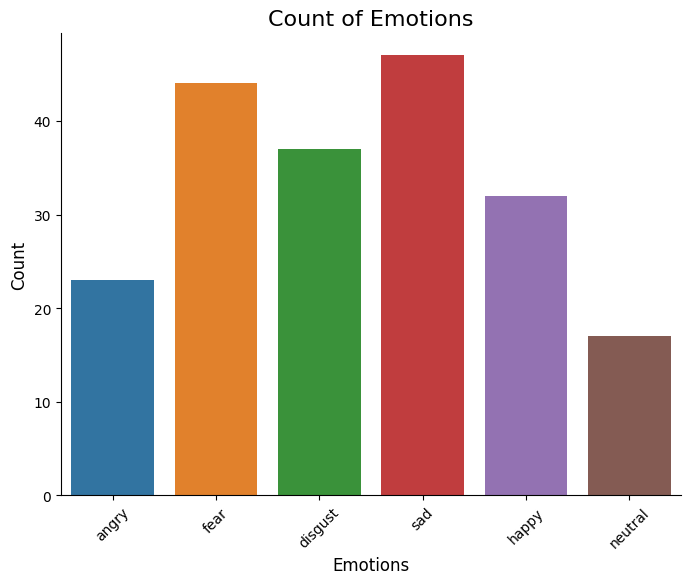

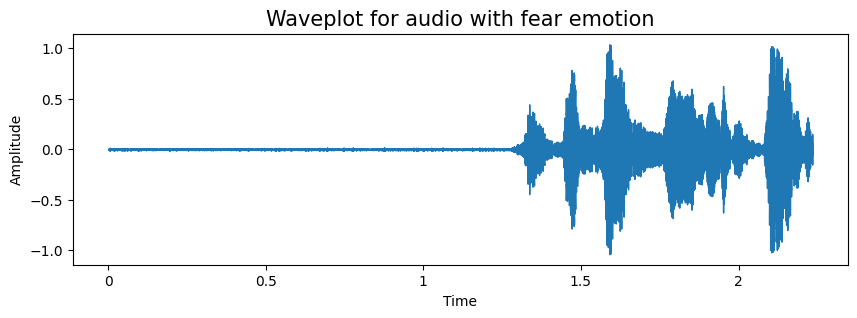

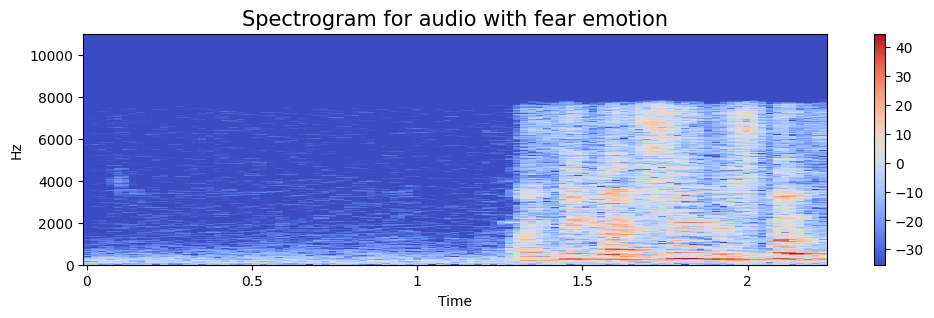

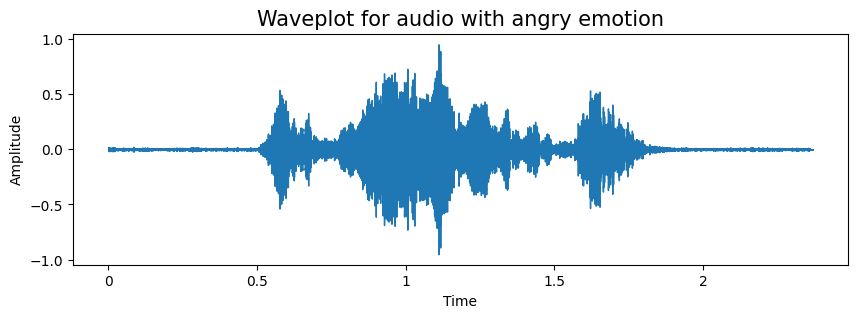

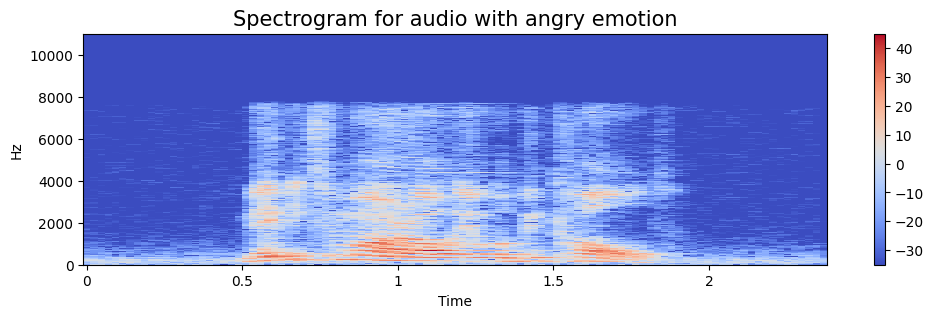

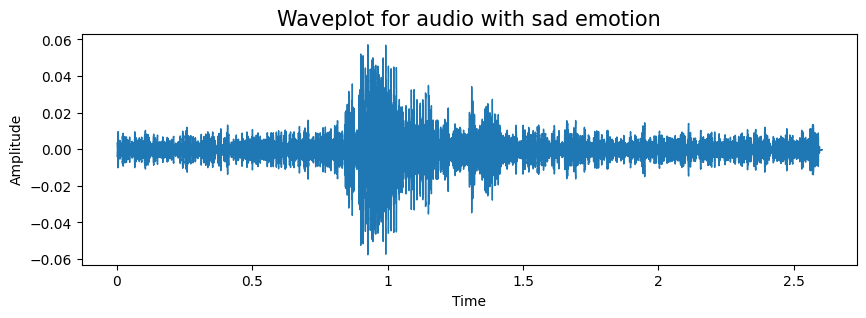

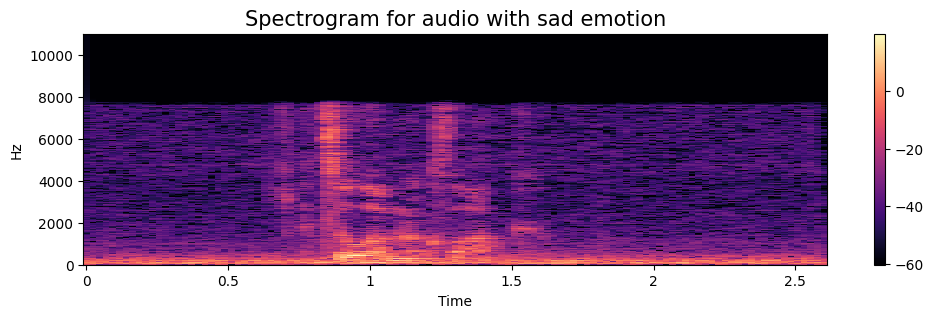

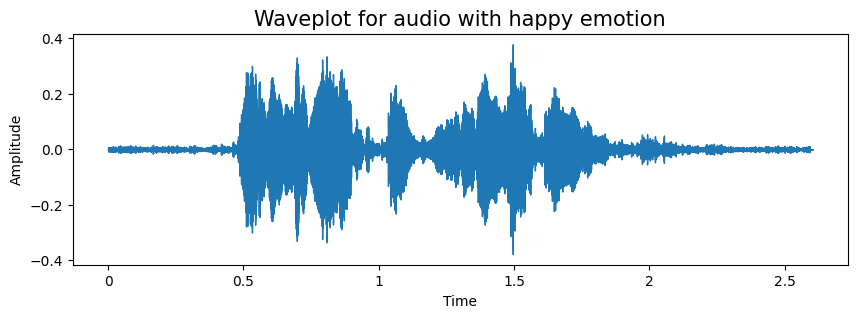

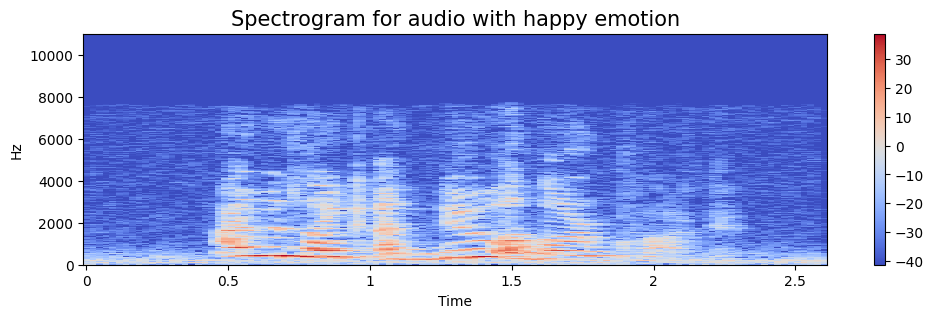

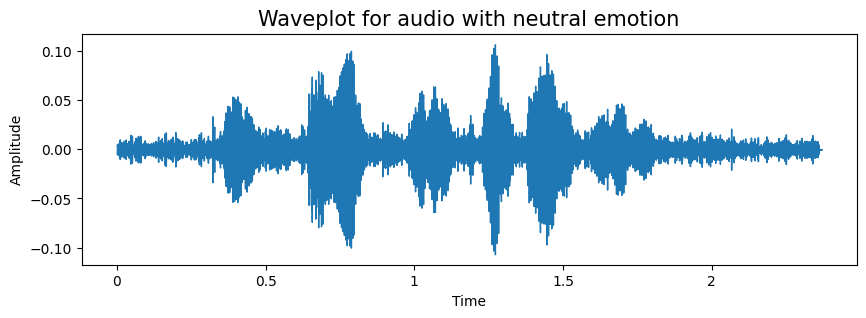

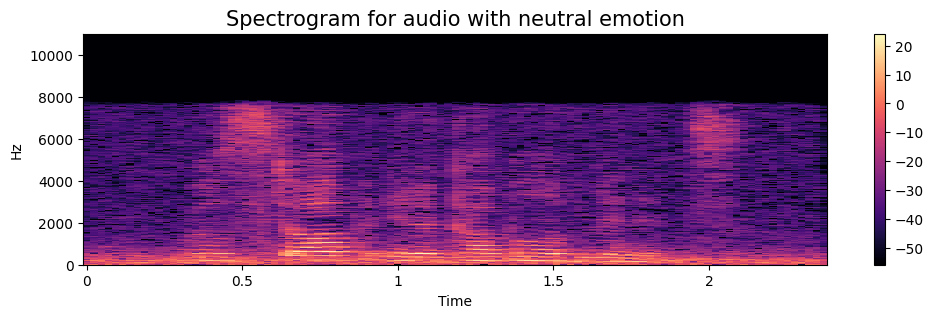

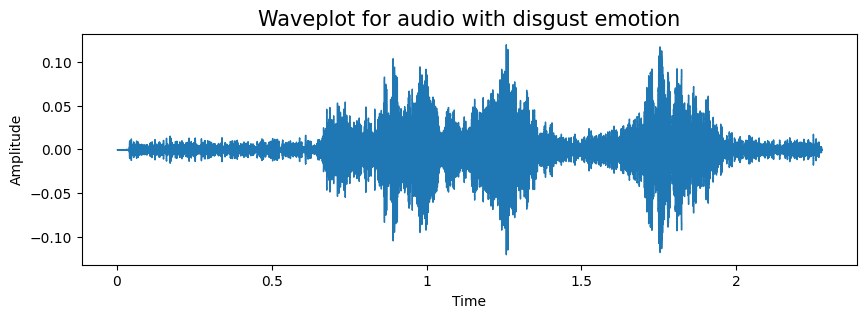

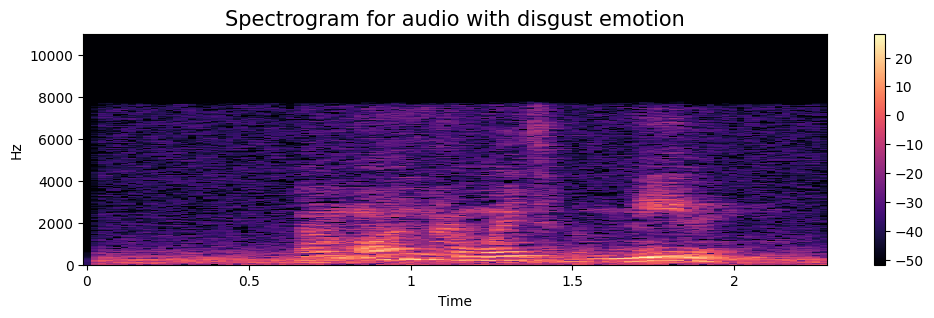

,emotionG_label,source,gender,emotion,path,melspectrogram_path
0,angry_male,CREMA,male,angry,/content/AudioWAV/1077_IOM_ANG_XX.wav,/content/Spectrogram/1077_IOM_ANG_XX.jpg
1,fear_male,CREMA,male,fear,/content/AudioWAV/1050_IEO_FEA_HI.wav,/content/Spectrogram/1050_IEO_FEA_HI.jpg
2,disgust_male,CREMA,male,disgust,/content/AudioWAV/1035_TAI_DIS_XX.wav,/content/Spectrogram/1035_TAI_DIS_XX.jpg
3,sad_male,CREMA,male,sad,/content/AudioWAV/1066_IEO_SAD_LO.wav,/content/Spectrogram/1066_IEO_SAD_LO.jpg
4,happy_male,CREMA,male,happy,/content/AudioWAV/1066_MTI_HAP_XX.wav,/content/Spectrogram/1066_MTI_HAP_XX.jpg
...,...,...,...,...,...,...
195,neutral_male,CREMA,male,neutral,/content/AudioWAV/1026_TAI_NEU_XX.wav,/content/Spectrogram/1026_TAI_NEU_XX.jpg
196,sad_male,CREMA,male,sad,/content/AudioWAV/1087_TAI_SAD_XX.wav,/content/Spectrogram/1087_TAI_SAD_XX.jpg
197,sad_female,CREMA,female,sad,/content/AudioWAV/1078_TAI_SAD_XX.wav,/content/Spectrogram/1078_TAI_SAD_XX.jpg
198,fear_male,CREMA,male,fear,/content/AudioWAV/1064_DFA_FEA_XX.wav,/content/Spectrogram/1064_DFA_FEA_XX.jpg


Epoch 1/50
5/5 [==============================] - ETA: 0s - loss: 2.8320 - accuracy: 0.1688
Epoch 1: saving model to models/epoch_(epoch).h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


5/5 [==============================] - 24s 5s/step - loss: 2.8320 - accuracy: 0.1688 - val_loss: 1.7635 - val_accuracy: 0.2812
Epoch 2/50
5/5 [==============================] - ETA: 0s - loss: 1.7984 - accuracy: 0.2000
Epoch 2: saving model to models/epoch_(epoch).h5
5/5 [==============================] - 22s 4s/step - loss: 1.7984 - accuracy: 0.2000 - val_loss: 1.7894 - val_accuracy: 0.2500
Epoch 3/50
5/5 [==============================] - ETA: 0s - loss: 1.7864 - accuracy: 0.2125
Epoch 3: saving model to models/epoch_(epoch).h5
5/5 [==============================] - 21s 4s/step - loss: 1.7864 - accuracy: 0.2125 - val_loss: 1.7831 - val_accuracy: 0.2500
Epoch 4/50
5/5 [==============================] - ETA: 0s - loss: 1.7773 - accuracy: 0.2313
Epoch 4: saving model to models/epoch_(epoch).h5
5/5 [==============================] - 22s 4s/step - loss: 1.7773 - accuracy: 0.2313 - val_loss: 1.7721 - val_accuracy: 0.2500
Epoch 5/50
5/5 [==============================] - ETA: 0s - loss: 1.7

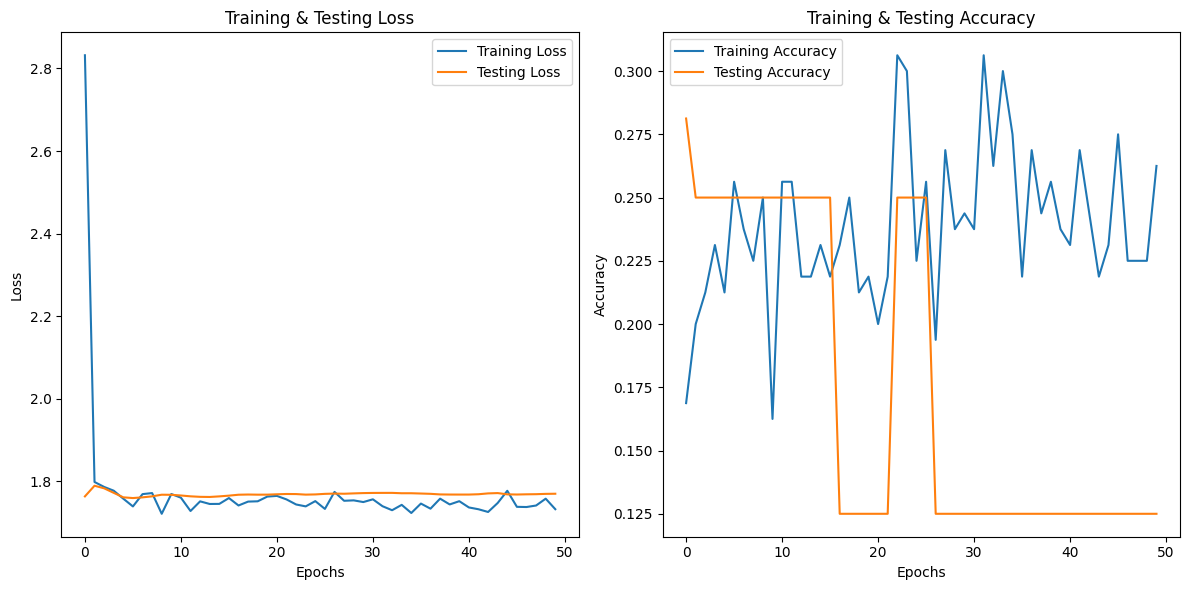

Epoch 1/50
29/29 [==============================] - 6s 128ms/step - loss: 3.8086 - accuracy: 0.2711 - val_loss: 1.8047 - val_accuracy: 0.4267
Epoch 2/50
29/29 [==============================] - 3s 110ms/step - loss: 1.9533 - accuracy: 0.3289 - val_loss: 2.3252 - val_accuracy: 0.2867
Epoch 3/50
29/29 [==============================] - 5s 164ms/step - loss: 1.9938 - accuracy: 0.3800 - val_loss: 1.9954 - val_accuracy: 0.3000
Epoch 4/50
29/29 [==============================] - 3s 115ms/step - loss: 1.3430 - accuracy: 0.4422 - val_loss: 1.4255 - val_accuracy: 0.4733
Epoch 5/50
29/29 [==============================] - 3s 111ms/step - loss: 1.2592 - accuracy: 0.4933 - val_loss: 1.3862 - val_accuracy: 0.4267
Epoch 6/50
29/29 [==============================] - 3s 110ms/step - loss: 1.2362 - accuracy: 0.4978 - val_loss: 1.3448 - val_accuracy: 0.4733
Epoch 7/50
29/29 [==============================] - 4s 156ms/step - loss: 1.8286 - accuracy: 0.4311 - val_loss: 1.8214 - val_accuracy: 0.3933
Epoch 

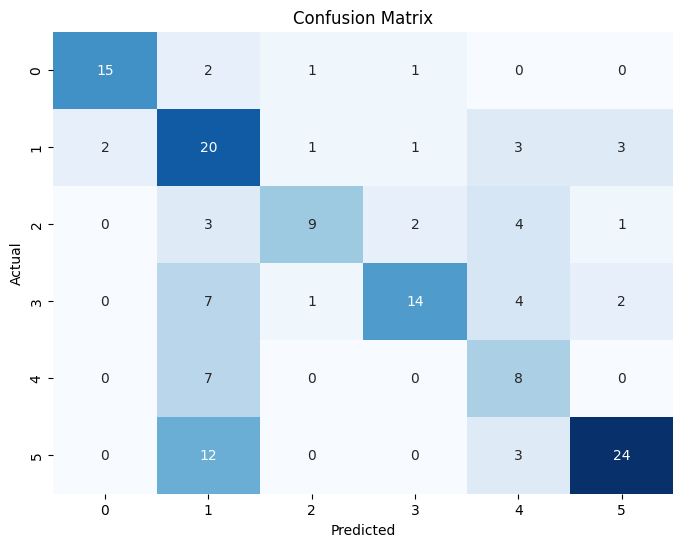

Accuracy: 60.00%


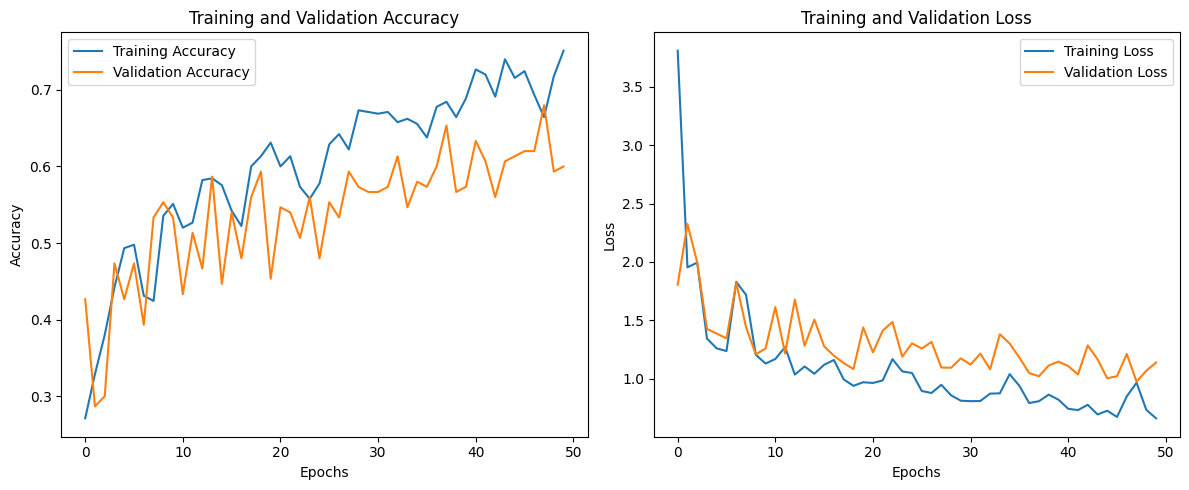

In [37]:
def main():
    data_prep = DataPreparation("/content/AudioWAV/")
    CREMA_df = data_prep.prepare_dataframe()

    visualization = DataVisualization(CREMA_df)
    visualization.plot_emotion_count()

    audio_visualizer = AudioVisualizer()
    emotions = ['fear', 'angry', 'sad', 'happy','neutral','disgust']

    for emotion in emotions:
        path = np.array(CREMA_df.path[CREMA_df.emotion == emotion])[1]
        data, sampling_rate = librosa.load(path)
        audio_visualizer.create_waveplot(data, sampling_rate, emotion)
        audio_visualizer.create_spectrogram(data, sampling_rate, emotion)
        display(Audio(path))


    spectrogram_creator = SpectrogramCreation(CREMA_df)
    spectrogram_creator.generate_spectrograms()

    label_encoder = LabelEncoder()
    # Encode the emotion column
    CREMA_df['emotion_encoded'] = label_encoder.fit_transform(CREMA_df['emotion'])

    #Split the DataFrame into features (X) and target labels (y)
    X = CREMA_df['melspectrogram_path']
    y = CREMA_df['emotion']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)

    # Create an instance of the ModelTraining class
    model_training = ModelTraining(ModelTraining.create_model())


    # Generate data for training and testing
    train_gen = model_training.data_generator(X_train, y_train_encoded)
    test_gen = model_training.data_generator(X_test, y_test_encoded)

    model_training.train_model(train_generator=train_gen, test_generator=test_gen,X_train= X_train,X_test=X_test)

    # Instantiate AudioFeatureExtractor
    audio_feature_extractor = AudioFeatureExtractor()

    path = np.array(CREMA_df.path)[1]
    audio_data, sample_rate = librosa.load(path) # Load audio data

    # Use AudioFeatureExtractor methods
#     noise_added_data = audio_feature_extractor.noise(audio_data)
#     stretched_data = audio_feature_extractor.stretch(audio_data)
#     shifted_data = audio_feature_extractor.shift(audio_data)
#     pitched_data = audio_feature_extractor.pitch(audio_data, sample_rate)
#     extracted_features = audio_feature_extractor.extract_features(audio_data)
#     features_from_path = audio_feature_extractor.get_features('path_to_audio_file.wav')

    X, Y = [], []
    for path, emotion in zip(CREMA_df.path, CREMA_df.emotion):
        feature = audio_feature_extractor.get_features(path)
        for ele in feature:
            X.append(ele)
            # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
            Y.append(emotion)

    Features = pd.DataFrame(X)
    Features['labels'] = Y

    X = Features.iloc[: ,:-1].values
    Y = Features['labels'].values

    # As this is a multiclass classification problem onehotencoding our Y.
    encoder = OneHotEncoder()
    Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

    # Instantiate EmotionRecognitionModel_MFCC
    emotion_model_mfcc = EmotionRecognitionModel_MFCC()

    # Example: Calling methods from EmotionRecognitionModel_MFCC
#     input_shape = (input_shape)  # Define your input shape
#     num_classes = (num_classes)  # Define the number of classes for your problem

    # Load your data for training and testing
    x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
    x_train.shape, y_train.shape, x_test.shape, y_test.shape

    # Build the model
    emotion_model_mfcc.build_model(x_train, x_test, y_train, y_test)

    # Compile the model
    emotion_model_mfcc.compile_model()

    # Train the model
    emotion_model_mfcc.train_model(x_train, y_train, x_test, y_test)

    # Evaluate the model
    emotion_model_mfcc.evaluate_model(x_test, y_test)

    # Plot training history
    emotion_model_mfcc.plot_training_history()

if __name__ == "__main__":
    main()


In [29]:
! rm Spectrogram/*